In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/content/data_banknote_authentication.csv")

In [4]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [9]:
df.isnull().sum()

,0
variance,0
skewness,0
curtosis,0
entropy,0
class,0


<Axes: >

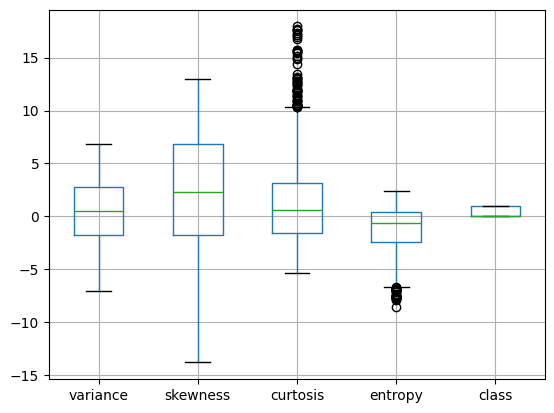

In [6]:
df.boxplot()

In [8]:
def outlier_t(data):
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  outliers = data[(data < lower_bound) | (data > upper_bound)]
  return len(outliers)


# Assuming df is your DataFrame and it has 'curtosis' and 'entropy' columns
curtosis_outliers = outlier_t(df['curtosis'])
entropy_outliers = outlier_t(df['entropy'])

print("Precentage of outlier in curtosis:", (curtosis_outliers/len(df))*100)
print("Number of outliers in entropy:", (entropy_outliers/len(df))*100)

Precentage of outlier in curtosis: 4.300291545189505
Number of outliers in entropy: 2.4052478134110786


In [12]:
Q1 = df.curtosis.quantile(0.25)
Q3 = df.curtosis.quantile(0.75)
max = Q3 + 1.5*(Q3-Q1)
min = Q1 - 1.5*(Q3-Q1)
max,min

(np.float64(10.3105875), np.float64(-8.7063125))

In [29]:
Q1_e = df.entropy.quantile(0.25)
Q3_e = df.entropy.quantile(0.75)
max_e = Q3 + 1.5*(Q3_e-Q1_e)
min_e = Q1 - 1.5*(Q3_e-Q1_e)
print(max_e)
print(min_e)

7.39164
-5.787365


In [20]:
def convert_c(x):
    if x>max:
        return max
    elif x<min:
        return min
    else:
        return x

In [21]:
df.curtosis = df.curtosis.map(convert_c)

In [30]:
def convert_e(x):
    if x>max_e:
        return max_e
    elif x<min_e:
        return min_e
    else:
        return x

In [31]:
df.entropy = df.entropy.map(convert_e)

<Axes: >

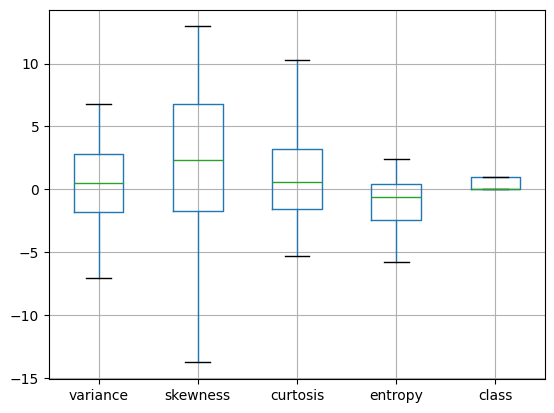

In [32]:
df.boxplot()

In [35]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

#Compute the mean vectors for each class
class_labels = np.unique(y)
mean_vectors = []
for cl in class_labels:
    mean_vectors.append(np.mean(X[y == cl], axis=0))

#Compute the within-class scatter matrix (S_W)
S_W = np.zeros((X.shape[1], X.shape[1]))
for cl, mv in zip(class_labels, mean_vectors):
    class_sc_mat = np.zeros((X.shape[1], X.shape[1]))  # Scatter matrix for each class
    for row in X[y == cl]:
        row, mv = row.reshape(X.shape[1], 1), mv.reshape(X.shape[1], 1)  # Reshape to column vectors
        class_sc_mat += (row - mv).dot((row - mv).T)
    S_W += class_sc_mat

In [36]:
#Compute the between-class scatter matrix (S_B)
overall_mean = np.mean(X, axis=0).reshape(X.shape[1], 1)
S_B = np.zeros((X.shape[1], X.shape[1]))
for i, mean_vec in enumerate(mean_vectors):
    n = X[y == class_labels[i]].shape[0]
    mean_vec = mean_vec.reshape(X.shape[1], 1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

#Solve the generalized eigenvalue problem for S_W^{-1} S_B
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

#Sort eigenvectors by decreasing eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

In [37]:
#Choose the top k eigenvectors (here k=2 for 2D projection)
W = np.hstack((eig_pairs[0][1].reshape(X.shape[1], 1), eig_pairs[1][1].reshape(X.shape[1], 1)))

#Project the data onto the new subspace
X_lda = X.dot(W)

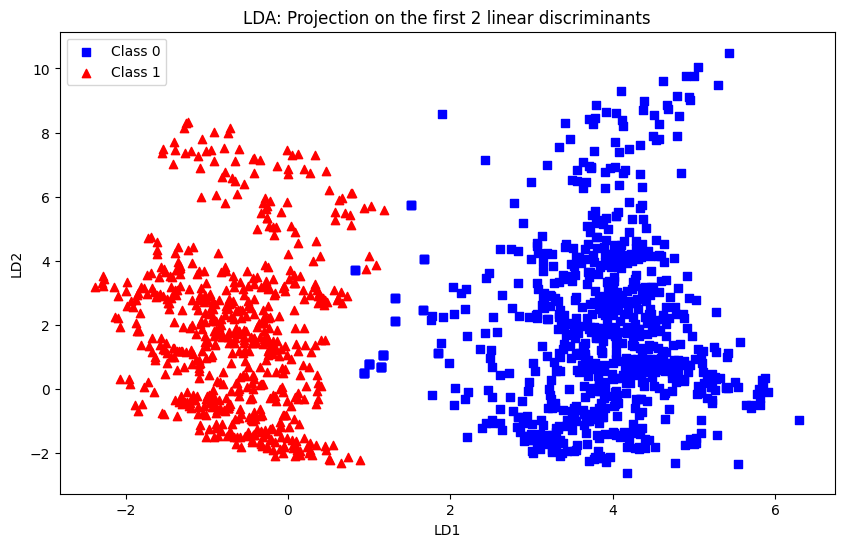

In [38]:
plt.figure(figsize=(10, 6))
for label, marker, color in zip(class_labels, ('s', '^'), ('blue', 'red')):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1],
                marker=marker, color=color, label=f'Class {label}')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA: Projection on the first 2 linear discriminants')
plt.legend()
plt.show()